#El entranamiento por transferencia
Cuando nos enfrentamos a un problema que requiere la aplicación de Machine Learning para su resolución y optamos por usar una red neuronal profunda, como primera tarea tendremos que escoger la arquitectura más adecuada para nuestro caso concreto. Una vez tomada esta decisión de diseño, nos encontramos ante el problema de inicializar sus parámetros; es decir, elegir el valor inicial de todas las constantes que multiplicarán (pesos) o se sumarán (bias) a las variables de entrada de cada capa en nuestra red. Hasta hace relativamente poco, lo más común solía ser inicializar estos parámetros de forma aleatoria dentro de un rango pequeño, para ayudar de alguna manera al algoritmo encargado de ajustar estos valores durante el entrenamiento. Como punto de partida no está mal (siempre es mejor que inicializarlos a cero) pero era un apartado con bastante margen de mejora

¿Y si en lugar de inicializar aleatoriamente los parámetros de nuestra red comenzáramos usando los valores obtenidos después de entrenar la misma arquitectura base con un conjunto enorme de imágenes etiquetadas donde ya existían gatos entre otras cosas? De esta forma estaríamos transfiriendo los conocimientos adquiridos en una tarea más genérica a nuestro caso particular, y no partiríamos totalmente de cero.

Esto es precisamente lo que nos aportan los modelos previamente entrenados. El caso quizá más conocido es el de la arquitectura ResNet, ganadora de la competición de reconocimiento de imágenes llevada a cabo por ImageNet en 2015. El hecho de usar la misma arquitectura con los mismos parámetros que un modelo pre-entrenado, otorgará a nuestra red la capacidad de reconocer bastantes cosas desde el comienzo, lo que además se traducirá en un tiempo de entrenamiento muy reducido. El uso de ImageNet como punto de partida ha supuesto un salto tremendo en el terreno de la visión artificial.

Lo que haremos en primer lugar como ya se ha mencionado antes, será escoger la arquitectura base, que dependerá del problema a resolver y de nuestro conocimiento de las mejores técnicas existentes para el tipo de escenario que se plantea.

Inicializaremos dicha arquitectura con los parámetros del modelo pre-entrenado, de forma que nuestros resultados finales sean mejores y se alcancen mucho antes. Lo que sigue a continuación es quitar la capa de salida de dicha arquitectura base y añadir en su lugar capas adicionales, de forma que podamos retocar el modelo original con el fin de reencauzarlo a nuestro problema concreto.

#Entrenamiento por transferencia de MobileNet

En nuestro ejemplo para clasificar entre gatos y perros usaremos un modelo ResNet pre-entrenado sobre MobileNet como punto de partida, quitaremos la capa de salida que nos decía si teníamos diversos objetos, y le añadiremos un par de capas finales para reorientar la tarea del modelo inicial, consiguiendo que el modelo resultante se centre en clasificar gatos y perros atendiendo a las diferencias observadas entre ellos.

Podemos seguir un procedimiento casi genérico a la hora de entrenar cualquier red usando transferencia de aprendizaje. Aplicaremos una táctica consistente en 2 etapas:

* En la primera etapa congelaremos los parámetros correspondientes a la arquitectura base. Sería un poco absurdo volver a ajustar los parámetros de las primeras capas de igual manera que los de las capas recién añadidas, ya que difícilmente mejoraremos la capacidad del modelo base para detectar por ejemplo formas simples, como pudieran ser diagonales o gradientes (algo que ya lograba la primera capa). Elegiremos una tasa de aprendizaje adecuada para el ajuste de los parámetros en las capas adicionales (no demasiado alta para prevenir oscilaciones, ni muy baja para evitar eternizarnos). El tiempo de entrenamiento será pequeño porque no son muchos los parámetros a ajustar; bastará con unas cuantas epochs (iteraciones completas sobre la totalidad de los datos).

* En la segunda etapa intentaremos mejorar el modelo realizando un ajuste fino. Lo primero que haremos es descongelar los parámetros del modelo base con el fin de poder ajustar mínimamente sus valores. Elegiremos un rango para la tasa de aprendizaje máxima en las distintas capas, de tal forma que los pesos iniciales varíen muy poco, mientras que los pesos finales tengan mayor margen de modificación (aunque menos que durante la primera etapa). Aquí en principio entrenaremos durante más epochs; básicamente hasta que el error de validación empeore de forma sostenida.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

68608000/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


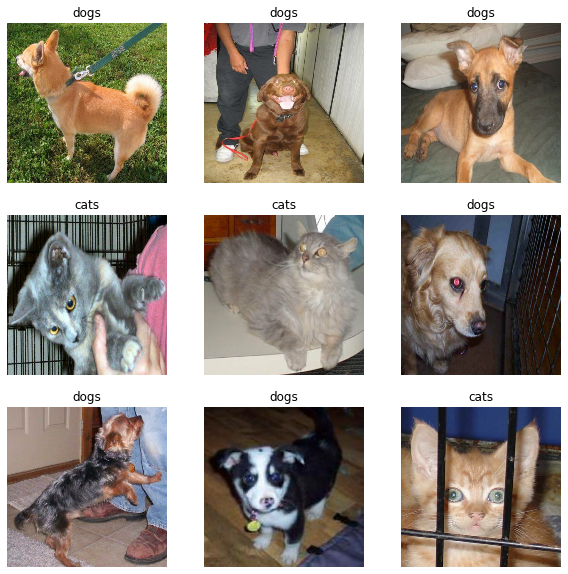

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.summary()

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [ ]:
base_model.trainable = False
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 1s 46ms/step - loss: 0.8023 - accuracy: 0.4740


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.80
initial accuracy: 0.47


In [ ]:
#Check on edit - notebook settings - gpu acceleration
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")